In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import nltk, gensim, os, re, warnings
import string, sys
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
warnings.filterwarnings('ignore')

In [3]:
df_en = pd.read_csv('../data/raw/en_train.csv')
df_fr = pd.read_csv('../data/raw/fr_train.csv')

In [4]:
df_en.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc


In [5]:
## description and types of data
#data_list = [df_en, df_fr]
def description_data(data):
    ## describe all
        data.describe(include='all')
        ## types of data
        print(f"The types of data is : {data.dtypes}\n")
        ## values misisng
        print(f"The missing values of dataset: {data.isnull().sum()}\n")
        ##douplons
        print(f"DOublons: {data.duplicated().sum()}") 
description_data(df_en)

The types of data is : review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

The missing values of dataset: review_id            0
product_id           0
reviewer_id          0
stars                0
review_body          0
review_title        33
language             0
product_category     0
dtype: int64

DOublons: 0


In [6]:
description_data(df_fr)

The types of data is : review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
dtype: object

The missing values of dataset: review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        4
language            0
product_category    0
dtype: int64

DOublons: 0


In [7]:
df_fr.shape, df_en.shape

((200000, 8), (200000, 8))

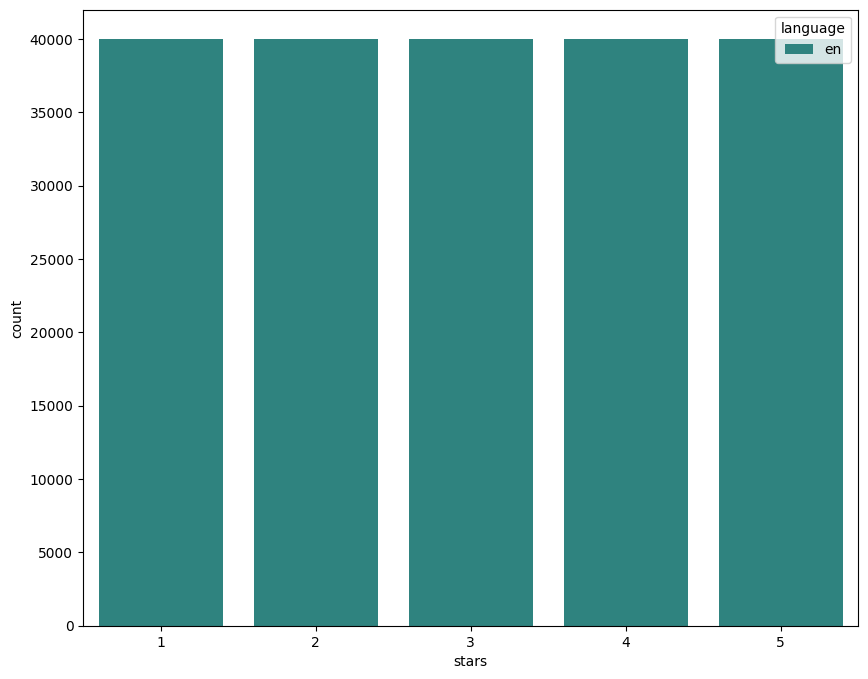

In [8]:
## merge the dataset df_fr
plt.figure(figsize=(10, 8))
sns.countplot(data = df_en, x = 'stars', hue='language', palette='viridis')
plt.show()
plt.close()


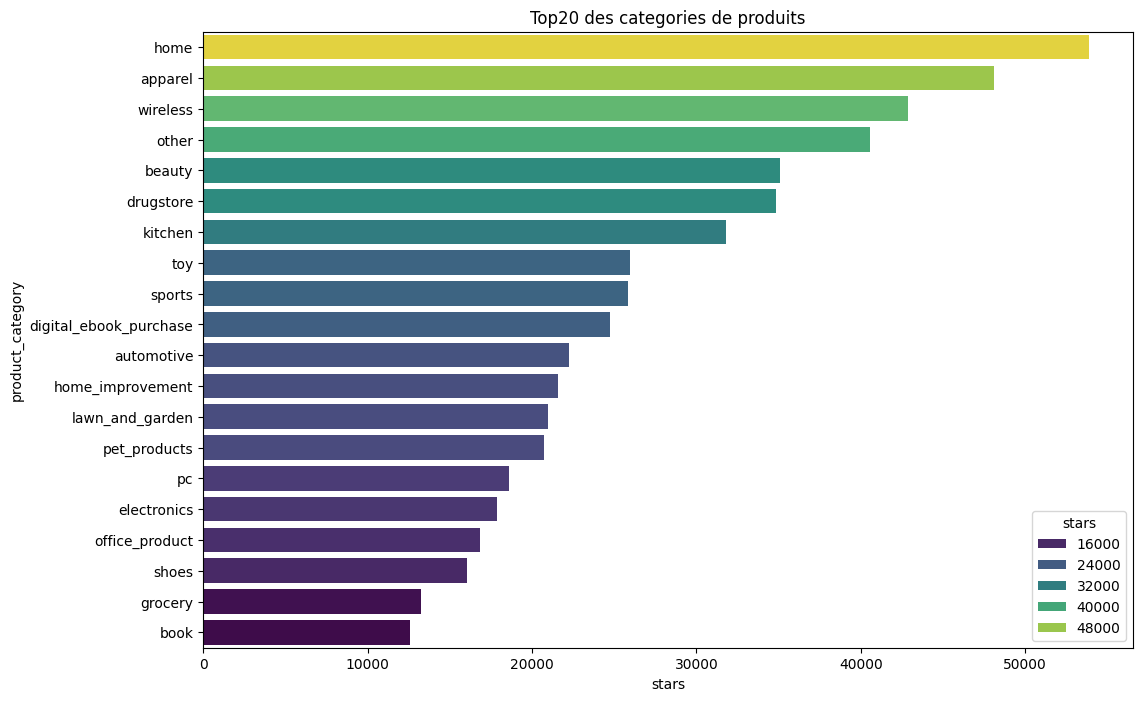

In [9]:
## top des 20 produits que les clients achettent
top20_product = df_en.groupby('product_category')['stars'].sum().reset_index().sort_values('stars', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x = 'stars', y = 'product_category', hue = 'stars', palette='viridis', data =top20_product.head(20))
plt.title("Top20 des categories de produits")
plt.show()
plt.close()

In [10]:
df_en['count_body'] = df_en['review_body'].apply(lambda x: len(x))
df_en.head(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,count_body
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture,612
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement,56
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home,206
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless,145
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc,91


<Axes: xlabel='Count', ylabel='count_body'>

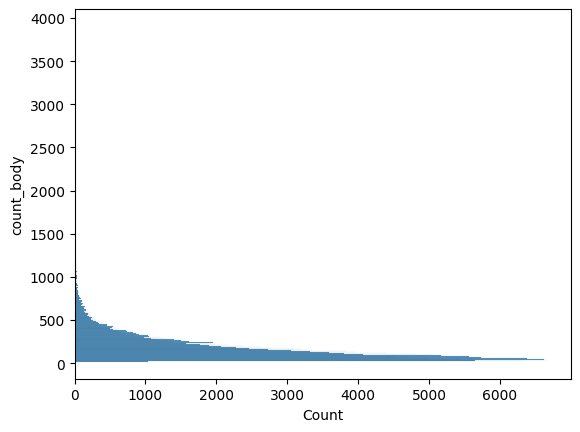

In [11]:
sns.histplot(data =df_en, y = 'count_body')

In [12]:
df = pd.concat([df_en, df_fr])

In [13]:
df.shape

(400000, 9)

In [14]:
language_fr = df.loc[df['language']=='fr', 'review_title']
language_fr

0                                       Brumisateur à pompe
1                                            Insatisfaisant
2                                         Ne recommande pas
3                                                 A éviter!
4                                                     Déçue
                                ...                        
199995                                                  Top
199996    Confirme à sa reputation de smartphone le plus...
199997                                             pratique
199998                            livré vite et bon produit
199999                                      Cartable garcon
Name: review_title, Length: 200000, dtype: object

In [15]:
language_fr_body = df.loc[df['language']=='fr', 'review_body']
language_fr_body

0         A déconseiller - Article n'a fonctionné qu'une...
1         Si vous voulez être déçu achetez le produit ! ...
2         Écran de mauvaise qualité, car il s'use en peu...
3         Cet engin ne sert à rien les sons sont pourris...
4         Très beau produit mais la grue n'a pas fonctio...
                                ...                        
199995    Très jolies boucles! Très belle qualité ! Elle...
199996    Superbe. Ultra rapide. Tres bel écran. Il y a ...
199997               facile d'utilisation mais un peu lourd
199998                            livré vite et bon produit
199999    Parfait La Réception du coli avant l’heure Pro...
Name: review_body, Length: 200000, dtype: object

In [16]:
### constitutions le jeu de données finales avec les colonnes pertinentes

dff = df[['stars', 'review_body', 'review_title']]
train = dff.sample(n=50000, random_state=42)
test = dff.sample(n=50000, random_state=42)
train.sample(5)

,stars,review_body,review_title
103737,3,I got this for my 5 YO daughter who loves the ...,"Cute, convenient, but quality could be better"
76221,2,Returned this product because the name of the ...,Beware the stake is plastic not metal
177127,5,"Offerts à mon fils pour son scooter, il les a ...",Tiennent chaud parfait pour conduire un 2 roues
53590,2,Très jolis petits paquets mais dans l'un des 2...,ne fonctionne pas sur 2 prises allume-cigare d...
47088,2,"They are cheaply made, the material insert kee...",Buy a better ring


In [17]:
train.shape, test.shape

((50000, 3), (50000, 3))

In [18]:
train['review'] = train['review_body'] + " " + train['review_title']
train.shape, train.isnull().sum(), train.head(10)

((50000, 4),
 stars           0
 review_body     0
 review_title    4
 review          4
 dtype: int64,
         stars                                        review_body  \
 23218       1  I still have not received my order ,it was sup...   
 20731       1  No when I sweat a lot it is forming a white la...   
 39555       1  I ordered a red violin case on Dec. 3 for my d...   
 147506      4  This thermometer comes as described and works ...   
 114215      3  Utilisé 1 fois et l’encre à séché très vite. P...   
 190913      5  Great little bag and doesn't slide off my chop...   
 96715       3  Je trouve cette coque vraiment jolie. La seule...   
 141482      4                             Its so soft. I love it   
 49119       2              Clips do not stay on very well at all   
 8005        1  Produit renvoyer car sur 10 ampoules seulement...   
 
                                              review_title  \
 23218                                       No. Order yet   
 20731     

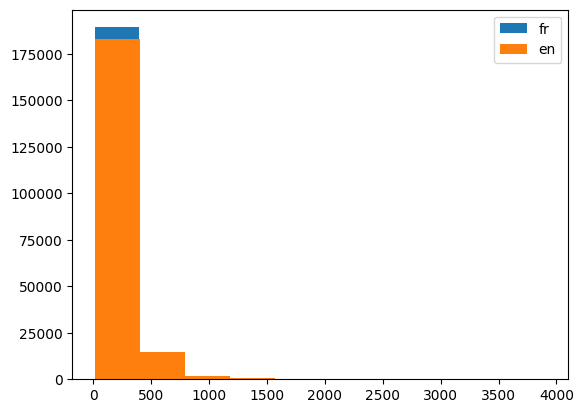

In [19]:
length_fr_review = df_fr['review_body'].str.len()
length_en_review = df_en['review_body'].str.len()

plt.hist(length_fr_review, label='fr')
plt.hist(length_en_review, label='en')
plt.legend()
plt.show()

In [20]:
def cleaning_text(text):
    
    ## verifier les valeurs manquantes
    if pd.isna(text):
        return ""
    ## transformer en miniscules
    ## supprimer les caraactères spéciaux, les ponctuations et les emojis
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(r"\d+", "", text) ## suppression des chiffres
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['review_clean'] = train['review'].apply(lambda y: cleaning_text(y))
train.head()

,stars,review_body,review_title,review,review_clean
23218,1,"I still have not received my order ,it was sup...",No. Order yet,"I still have not received my order ,it was sup...",i still have not received my order it was supp...
20731,1,No when I sweat a lot it is forming a white la...,One Star,No when I sweat a lot it is forming a white la...,no when i sweat a lot it is forming a white la...
39555,1,I ordered a red violin case on Dec. 3 for my d...,I was so disappointed when I opened the box,I ordered a red violin case on Dec. 3 for my d...,i ordered a red violin case on dec for my daug...
147506,4,This thermometer comes as described and works ...,Nice and accurate thermometer,This thermometer comes as described and works ...,this thermometer comes as described and works ...
114215,3,Utilisé 1 fois et l’encre à séché très vite. P...,Bof,Utilisé 1 fois et l’encre à séché très vite. P...,utilis fois et lencre sch trs vite plus habitu...


In [21]:
### identifying the sentiment of text

def attribut_label(star):
    
    if star < 3:
        return "negative"
    elif star == 3:
        return "neutral"
    elif star >= 4:
        return "positive"
    else:
        return "unknown"
    
train['target'] = train['stars'].apply(lambda z: attribut_label(z))
train[:10]
    

,stars,review_body,review_title,review,review_clean,target
23218,1,"I still have not received my order ,it was sup...",No. Order yet,"I still have not received my order ,it was sup...",i still have not received my order it was supp...,negative
20731,1,No when I sweat a lot it is forming a white la...,One Star,No when I sweat a lot it is forming a white la...,no when i sweat a lot it is forming a white la...,negative
39555,1,I ordered a red violin case on Dec. 3 for my d...,I was so disappointed when I opened the box,I ordered a red violin case on Dec. 3 for my d...,i ordered a red violin case on dec for my daug...,negative
147506,4,This thermometer comes as described and works ...,Nice and accurate thermometer,This thermometer comes as described and works ...,this thermometer comes as described and works ...,positive
114215,3,Utilisé 1 fois et l’encre à séché très vite. P...,Bof,Utilisé 1 fois et l’encre à séché très vite. P...,utilis fois et lencre sch trs vite plus habitu...,neutral
190913,5,Great little bag and doesn't slide off my chop...,Good value,Great little bag and doesn't slide off my chop...,great little bag and doesnt slide off my chopp...,positive
96715,3,Je trouve cette coque vraiment jolie. La seule...,Ne protège que partiellement les contours du s...,Je trouve cette coque vraiment jolie. La seule...,je trouve cette coque vraiment jolie la seule ...,neutral
141482,4,Its so soft. I love it,Great quality,Its so soft. I love it Great quality,its so soft i love it great quality,positive
49119,2,Clips do not stay on very well at all,Flimsy not worth it,Clips do not stay on very well at all Flimsy n...,clips do not stay on very well at all flimsy n...,negative
8005,1,Produit renvoyer car sur 10 ampoules seulement...,Ne recommande pas le produit,Produit renvoyer car sur 10 ampoules seulement...,produit renvoyer car sur ampoules seulement ou...,negative


In [22]:
train['stars'].value_counts()

stars
5    10092
3    10036
4    10022
1     9949
2     9901
Name: count, dtype: int64

In [23]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('all')


[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading all: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [24]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [25]:
## pretraitement of texte

def preprocess_text(text):
    
    ## tokenizer le texte
    token = word_tokenize(text)
    ## supprimer les stopwords
    stop_words = set(stopwords.words("english")) | set(stopwords.words('french'))
    tokens = [word for word in token if word not in stop_words]
    lematizer = WordNetLemmatizer()
    tokens= [lematizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

train['review_text'] = train['review_clean'].apply(lambda t:preprocess_text(t))
train[:10]

,stars,review_body,review_title,review,review_clean,target,review_text
23218,1,"I still have not received my order ,it was sup...",No. Order yet,"I still have not received my order ,it was sup...",i still have not received my order it was supp...,negative,still received order supposed two day day orde...
20731,1,No when I sweat a lot it is forming a white la...,One Star,No when I sweat a lot it is forming a white la...,no when i sweat a lot it is forming a white la...,negative,sweat lot forming white layer back watch one star
39555,1,I ordered a red violin case on Dec. 3 for my d...,I was so disappointed when I opened the box,I ordered a red violin case on Dec. 3 for my d...,i ordered a red violin case on dec for my daug...,negative,ordered red violin case dec daughter christmas...
147506,4,This thermometer comes as described and works ...,Nice and accurate thermometer,This thermometer comes as described and works ...,this thermometer comes as described and works ...,positive,thermometer come described work great easy use...
114215,3,Utilisé 1 fois et l’encre à séché très vite. P...,Bof,Utilisé 1 fois et l’encre à séché très vite. P...,utilis fois et lencre sch trs vite plus habitu...,neutral,utilis fois lencre sch trs vite plus habitue f...
190913,5,Great little bag and doesn't slide off my chop...,Good value,Great little bag and doesn't slide off my chop...,great little bag and doesnt slide off my chopp...,positive,great little bag doesnt slide chopper tank way...
96715,3,Je trouve cette coque vraiment jolie. La seule...,Ne protège que partiellement les contours du s...,Je trouve cette coque vraiment jolie. La seule...,je trouve cette coque vraiment jolie la seule ...,neutral,trouve cette coque vraiment jolie seule chose ...
141482,4,Its so soft. I love it,Great quality,Its so soft. I love it Great quality,its so soft i love it great quality,positive,soft love great quality
49119,2,Clips do not stay on very well at all,Flimsy not worth it,Clips do not stay on very well at all Flimsy n...,clips do not stay on very well at all flimsy n...,negative,clip stay well flimsy worth
8005,1,Produit renvoyer car sur 10 ampoules seulement...,Ne recommande pas le produit,Produit renvoyer car sur 10 ampoules seulement...,produit renvoyer car sur ampoules seulement ou...,negative,produit renvoyer car ampoule seulement fonctio...


In [26]:
from sklearn.preprocessing import LabelEncoder
X = train['review_text']
encoder = LabelEncoder()
y = encoder.fit_transform(train['target'])

xtrain, xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((35000,), (15000,), (35000,), (15000,))

In [27]:
### vectorize the sentence of review

def vectorize_sentences(xtrain, xtest):
    vectorizer =TfidfVectorizer(max_features=10000, analyzer="word", min_df=5)
    Xtrain= vectorizer.fit_transform(xtrain)
    Xtest = vectorizer.transform(xtest)
    return Xtrain, Xtest

Xtrain, Xtest = vectorize_sentences(xtrain=xtrain, xtest=xtest)

In [28]:
train.to_csv('../data/processed/train.csv', index=False)
test.to_csv('../data/processed/test.csv', index=False)

In [29]:
Xtrain.shape, Xtest.shape

((35000, 9761), (15000, 9761))

In [30]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
models = [
	("Logistic Regression", LogisticRegression()),
	("BernoulliNB", BernoulliNB()),
	#("GaussianNB", GaussianNB()),
	#("SVM", SVC())
 
]

for name, model in models:
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    print(f"Accuracy for {name}")
    print(accuracy_score(ytest, ypred))
    print(f"Precision for {name}")
    print(precision_score(ytest, ypred, average='macro'))
    print(f"f1 score for {name}")
    print(f1_score(ytest, ypred, average="macro"))
    print(f"Classification report for {name}")
    print(classification_report(ytest, ypred))

Accuracy for Logistic Regression
0.7256
Precision for Logistic Regression
0.6670007607922289
f1 score for Logistic Regression
0.6423992609908935
Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      5955
           1       0.50      0.25      0.34      3011
           2       0.76      0.85      0.80      6034

    accuracy                           0.73     15000
   macro avg       0.67      0.65      0.64     15000
weighted avg       0.70      0.73      0.70     15000

Accuracy for BernoulliNB
0.6892666666666667
Precision for BernoulliNB
0.6299669433260914
f1 score for BernoulliNB
0.6252630056750608
Classification report for BernoulliNB
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      5955
           1       0.40      0.31      0.35      3011
           2       0.72      0.82      0.77      6034

    accuracy                           

In [31]:
y[20:]

array([0, 2, 0, ..., 0, 2, 0])

In [33]:
log = LogisticRegression(penalty='l2', C=1.0, fit_intercept=True, tol=0.001, solver='lbfgs', max_iter=100, multi_class='ovr',
                         verbose=1, n_jobs=1, l1_ratio=0.1)

score_vector = cross_val_score(log, Xtrain, ytrain, scoring='f1', cv=5)
log.get_params

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.03000D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     12     18      1     0     0   3.049D-04   4.018D-01
  F =  0.40184602691505528     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.99286D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     18     19      1     0     0   6.311D-04   4.194D-01
  F =  0.41938072137529891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  9.77143D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762      8     14      1     0     0   7.566D-04   3.862D-01
  F =  0.38615485543893469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.03000D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     12     18      1     0     0   6.312D-04   4.029D-01
  F =  0.40287469612084958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.99286D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     25     27      1     0     0   9.777D-04   4.123D-01
  F =  0.41230793338290839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  9.77143D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     12     18      1     0     0   3.283D-04   4.023D-01
  F =  0.40230215876002673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.99286D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762      9     14      1     0     0   5.588D-04   3.834D-01
  F =  0.38337168121654774     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.03000D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.99286D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     18     19      1     0     0   6.011D-04   4.197D-01
  F =  0.41974223587379245     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.9

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762      8     14      1     0     0   8.115D-04   3.862D-01
  F =  0.38623632020153814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.03000D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9762     18     19      1     0     0   7.152D-04   4.196D-01
  F =  0.41957098288855332     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9762     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  9.77143D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

<bound method BaseEstimator.get_params of LogisticRegression(l1_ratio=0.1, multi_class='ovr', n_jobs=1, tol=0.001,
                   verbose=1)>

In [37]:
final_model = LogisticRegression(penalty='l2', solver="lbfgs", C=1.0, tol=0.001)
final_model.fit(Xtrain, ytrain)
prediction = final_model.predict(Xtest)

scoring = accuracy_score(ytest, prediction)
print(scoring)

0.7246


In [44]:
import joblib, pickle

with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)